<center>
    
# Synthetic Generation of 17th-Century Spanish Book Pages
</center>

## Introduction

This notebook presents our solution for the synthetic generation of 17th-century Spanish book page images, designed to replicate the aesthetic of historical documents. The goal is to create realistic synthetic images that can be used for tasks such as data augmentation, historical simulation, or training OCR systems. Our approach follows a two-step process to ensure both the background and text overlay align with the visual characteristics of 17th-century Spanish books, such as aged parchment, historical fonts, and formal text layouts.

## Two-Step Process

### Step 1: Background Generation
- **Objective**: Generate a realistic background that mimics the aged parchment of a 17th-century book page.
- **Method**: We use a diffusion generative model(`runwayml/stable-diffusion-v1-5`) to create background images with the following characteristics:
  - Yellowish-grayish-brown tone to simulate aged paper.
  - Subtle ink stains, worn edges, and faded textures for authenticity.
  - No pre-existing text on the background to allow for clean text overlay.
- **Output**: Background images are saved in `./back_photos/run6` (e.g., `synthetic_page_3.png`).

### Step 2: Text Overlay
- **Objective**: Overlay transcribed text onto the generated background, styled to match the 17th-century aesthetic.
- **Method**:
  - **Text Extraction**: Extract text from a `.docx` file (`Buendia transcription.docx`) containing transcriptions of historical content.
  - **Text Splitting**: Split the text into pages, with each page containing up to 24 lines and lines limited to ~50 characters to match historical line lengths.
  - **Font and Styling**: Use the "IM Fell English" font (`./font/IMFellEnglish-Regular.ttf`), a historical serif typeface, with a font size of 18 points and tight line spacing (20 pixels) to replicate the compact, formal layout of the period.
  - **Text Positioning**: Center the text block horizontally and vertically, with reduced margins (top margin of 30 pixels) to maximize text density.
  - **Background Adjustment**: Apply a grayish-brown tint to the background to enhance the aged parchment effect while preserving texture.
- **Output**: Augmented images with overlaid text are saved in `./final_gen` (e.g., `augmented_page_0_page_0.png`).

## Key Features
- **Historical Accuracy**: The solution replicates the visual style of 17th-century Spanish book pages, including aged parchment, historical fonts, and formal text layouts.
- **Flexibility**: The two-step process allows for independent improvement of the background generation and text overlay, ensuring adaptability to different requirements.
- **Text Density**: Matches the reference sample with 24 lines per page, longer lines (~50 characters), tight line spacing, and narrow margins for a compact, formal appearance.
- **Aging Effects**: Optional text aging effects (e.g., blur and noise) can be applied to simulate aged ink, enhancing realism.


In [14]:
# Environment Setup
# !pip install diffusers transformers opencv-python scikit-image pytorch-lightning pdf2image reportlab accelerate python-docx

## Initial testing and training on our dataset

We first visualise the images it generated without any training and just specific prompt:

```
background_prompt = "A realistic 17th-century plain page background, in focus, aged yellow or white parchment with subtle ink stains, worn edges, faded texture, no text, no abstract patterns, soft lighting"
negative_prompt = "text, letters, words, writing, script, book spine, book cover, book edge, 3D book"
   ```

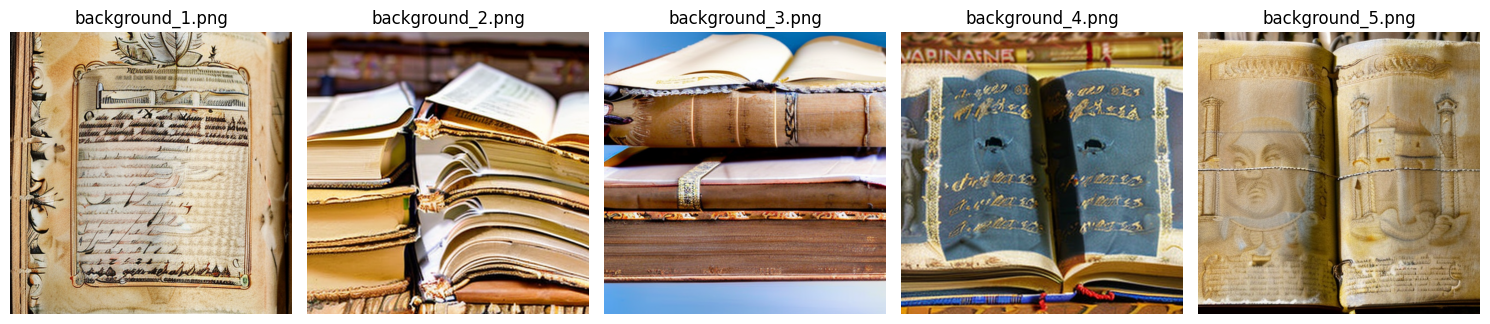

In [17]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_images(directory, num_images=5):
    """
    Displays a specified number of images from a directory in a Jupyter Notebook.
    
    Parameters:
        directory (str): Path to the directory containing images.
        num_images (int): Number of images to display.
    """
    # Filter image files in the directory
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    # Sort and limit the number of images to display
    image_files = sorted(image_files)[:num_images]
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
    
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(directory, image_file)
        img = Image.open(img_path)
        
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(image_file)
    
    plt.tight_layout()
    plt.show()


display_images("./back_photos/run1", num_images=5)


Without training the model generated above images. It does have some positive characteristics like books, pages but also has lots of details in background, faint text which is not suitable for our task in hand. This can be due to more general dataset the model has been trained on. We will now try to improve on this by training the model on our masked images to generate background images. 

- The model weights are save at: `./gen_model`.
- Train for 50 steps due to limited resources/ MPS memory issues on Mac


Command to train: 

```
accelerate launch \
    --num_processes=1 \
    --num_machines=1 \
    ./diffusers/examples/text_to_image/train_text_to_image.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --dataset_name="./preprocessed_images" \
    --resolution=512 \
    --center_crop \
    --random_flip \
    --train_batch_size=1 \
    --num_train_epochs=10 \
    --max_train_steps=50 \
    --learning_rate=1e-7 \
    --gradient_accumulation_steps=1 \
    --caption_column="prompt" \
    --output_dir="./gen_model" \
    --validation_prompt="A 17th-century Spanish book page background, aged yellow parchment with subtle ink stains, worn edges, faded texture, no text" \
    --validation_epochs=1 \
    --gradient_checkpointing \
    --max_grad_norm=0.1

```
### Note: 
Please not that below results were finalized after multiple runs across multiple hyperparameter tuning, trying to avoid memory issues while also trying to keep the run time for training managebale.
Training results are as follows:

```
Resolving data files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 577068.67it/s]
04/01/2025 22:05:52 - INFO - __main__ - ***** Running training *****
04/01/2025 22:05:52 - INFO - __main__ -   Num examples = 40
04/01/2025 22:05:52 - INFO - __main__ -   Num Epochs = 2
04/01/2025 22:05:52 - INFO - __main__ -   Instantaneous batch size per device = 1
04/01/2025 22:05:52 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 1
04/01/2025 22:05:52 - INFO - __main__ -   Gradient Accumulation steps = 1
04/01/2025 22:05:52 - INFO - __main__ -   Total optimization steps = 50
Steps:   0%|                                                                                                                                                                                   | 0/50 [00:00<?, ?it/s]04/01/2025 22:05:55 - INFO - __main__ - Latents stats at step 0 - min: -2.4708993434906006, max: 3.751457452774048
Steps:   2%|██▉                                                                                                                                             | 1/50 [00:25<21:06, 25.84s/it, lr=1e-7, step_loss=0.0177]04/01/2025 22:06:21 - INFO - __main__ - Latents stats at step 1 - min: -2.4093453884124756, max: 3.987030029296875
Steps:   4%|█████▊                                                                                                                                           | 2/50 [00:56<22:56, 28.68s/it, lr=1e-7, step_loss=0.315]04/01/2025 22:06:51 - INFO - __main__ - Latents stats at step 2 - min: -2.127285957336426, max: 4.384716510772705
Steps:   6%|████████▌                                                                                                                                      | 3/50 [01:28<23:35, 30.11s/it, lr=1e-7, step_loss=0.00514]04/01/2025 22:07:24 - INFO - __main__ - Latents stats at step 3 - min: -10.117029190063477, max: 8.253686904907227
Steps:   8%|███████████▌                                                                                                                                     | 4/50 [01:59<23:29, 30.64s/it, lr=1e-7, step_loss=0.115]04/01/2025 22:07:54 - INFO - __main__ - Latents stats at step 4 - min: -3.4608404636383057, max: 4.555289268493652
Steps:  10%|██████████████▎                                                                                                                                | 5/50 [02:30<23:03, 30.73s/it, lr=1e-7, step_loss=0.00806]04/01/2025 22:08:25 - INFO - __main__ - Latents stats at step 5 - min: -4.875211715698242, max: 4.869713306427002
Steps:  12%|█████████████████▎                                                                                                                              | 6/50 [02:59<21:59, 30.00s/it, lr=1e-7, step_loss=0.0286]04/01/2025 22:0
.
.
.
.
.
.


04/01/2025 22:30:42 - INFO - __main__ - Latents stats at step 6 - min: -2.409358024597168, max: 3.987029790878296
Steps:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47/50 [25:15<01:35, 31.97s/it, lr=1e-7, step_loss=0.0571]04/01/2025 22:31:10 - INFO - __main__ - Latents stats at step 7 - min: -2.8750314712524414, max: 3.727713108062744
Steps:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 48/50 [25:43<01:01, 30.89s/it, lr=1e-7, step_loss=0.218]04/01/2025 22:31:39 - INFO - __main__ - Latents stats at step 8 - min: -3.2127952575683594, max: 4.621719837188721
Steps:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 49/50 [26:15<00:30, 30.99s/it, lr=1e-7, step_loss=0.0654]04/01/2025 22:32:10 - INFO - __main__ - Latents stats at step 9 - min: -12.752649307250977, max: 8.079279899597168
Steps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [26:45<00:00, 30.77s/it, lr=1e-7, step_loss=0.0159]04/01/2025 22:32:38 - INFO - __main__ - Running validation... 
{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.
                                                                                                                                                                                                                     Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.                                                                             | 0/6 [00:00<?, ?it/s]
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 264.15it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.
                                                                                                                                                                                                                     Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.                                                                             | 0/7 [00:00<?, ?it/s]
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of runwayml/stable-diffusion-v1-5.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.59it/s]
Configuration saved in ./gen_model/vae/config.json██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.61it/s]
Model weights saved in ./gen_model/vae/diffusion_pytorch_model.safetensors
Configuration saved in ./gen_model/unet/config.json
Model weights saved in ./gen_model/unet/diffusion_pytorch_model.safetensors
Configuration saved in ./gen_model/scheduler/scheduler_config.json
Configuration saved in ./gen_model/model_index.json

```

## Image Generation
Post finetuning, let's look at what images are generated by our diffusion model:


Post-VAE min/max: -1.3249346017837524 0.9758789539337158
Post-norm min/max: 0.0 0.9879394769668579
Post-VAE min/max: -0.9248195290565491 1.0903055667877197
Post-norm min/max: 0.037590235471725464 1.0
Post-VAE min/max: -0.8490081429481506 0.6864950060844421
Post-norm min/max: 0.07549592852592468 0.8432475328445435
Post-VAE min/max: -0.9269920587539673 0.5171752572059631
Post-norm min/max: 0.03650397062301636 0.7585875988006592
Post-VAE min/max: -1.1003177165985107 0.9578936100006104
Post-norm min/max: 0.0 0.9789468050003052
Image 1 shape: (512, 512, 3), min/max: 0.0, 0.9879394769668579
Image 2 shape: (512, 512, 3), min/max: 0.037590235471725464, 1.0
Image 3 shape: (512, 512, 3), min/max: 0.07549592852592468, 0.8432475328445435
Image 4 shape: (512, 512, 3), min/max: 0.03650397062301636, 0.7585875988006592
Image 5 shape: (512, 512, 3), min/max: 0.0, 0.9789468050003052


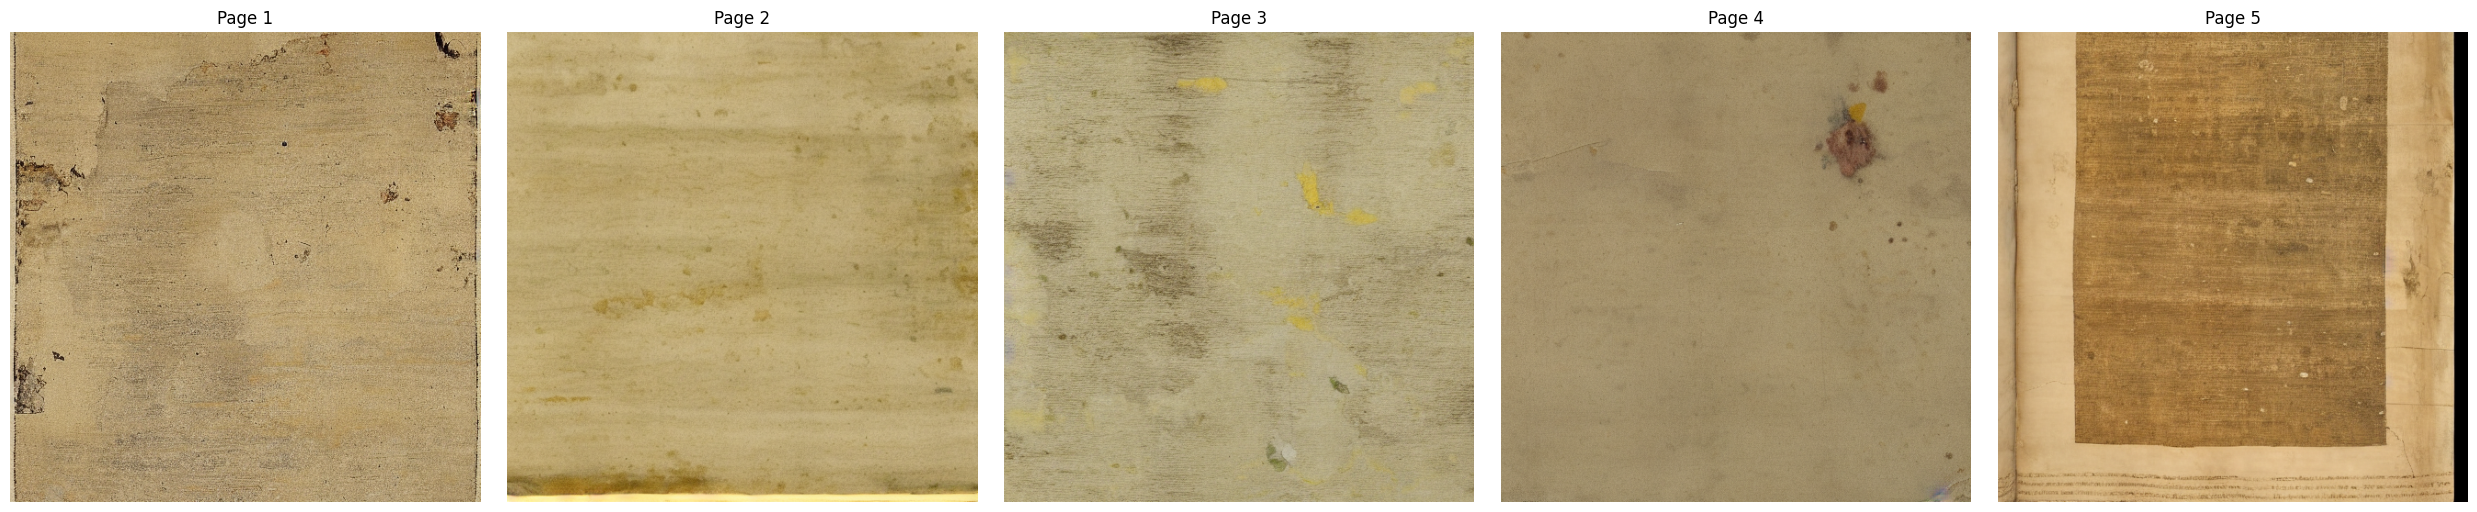

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel
from torchvision.transforms.functional import rotate
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

class RenaissanceDiffuser(nn.Module):
    def __init__(self):
        super().__init__()
        self.vae = AutoencoderKL.from_pretrained("./gen_model", subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained("./gen_model", subfolder="unet").to(device)
        self.scheduler = DDPMScheduler.from_pretrained("./gen_model", subfolder="scheduler")
        self.text_encoder = CLIPTextModel.from_pretrained("./gen_model", subfolder="text_encoder").to(device)

    def generate_background(self, text_prompt, negative_prompt="", num_steps=200, guidance_scale=7.5):
        with torch.no_grad():
            from transformers import CLIPTokenizer
            tokenizer = CLIPTokenizer.from_pretrained("./gen_model", subfolder="tokenizer")
            
            # Tokenize positive and negative prompts
            text_input = tokenizer(text_prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
            text_embeddings = self.text_encoder(text_input.input_ids)[0]
            
            if negative_prompt:
                neg_input = tokenizer(negative_prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
                neg_embeddings = self.text_encoder(neg_input.input_ids)[0]
            else:
                neg_embeddings = torch.zeros_like(text_embeddings)

            latent = torch.randn(1, 4, 64, 64).to(device)
            self.scheduler.set_timesteps(num_steps)
            for t in self.scheduler.timesteps:
                # Predict noise with unconditional and conditional embeddings
                latent_model_input = torch.cat([latent] * 2)
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=torch.cat([neg_embeddings, text_embeddings])).sample
                
                # Classifier-free guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                
                latent = self.scheduler.step(noise_pred, t, latent).prev_sample
            
            image = self.vae.decode(latent / 0.18215).sample
            print("Post-VAE min/max:", image.min().item(), image.max().item())
            image = (image / 2 + 0.5).clamp(0, 1)  # RGB [1, 3, 512, 512]
            print("Post-norm min/max:", image.min().item(), image.max().item())
        return image

def generate_pages(num_pages=5):
    model = RenaissanceDiffuser().to(device)
    generated_images = []
    background_prompt = "A realistic 17th-century plain page background, in focus, aged yellow or white parchment with subtle ink stains, worn edges, faded texture, no text, no abstract patterns, soft lighting"
    negative_prompt = "text, letters, words, writing, script, book spine, book cover, book edge, 3D book"
    
    for i in range(num_pages):
        background = model.generate_background(background_prompt, negative_prompt, num_steps=200, guidance_scale=7.5)
        # Save raw background for debugging
        background_np = background.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        Image.fromarray((background_np * 255).astype(np.uint8)).save(f"background_{i+1}.png")
        generated_images.append(background)
    return generated_images

def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    if num_images == 1:
        axes = [axes]
    for i, img in enumerate(images):
        img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # [512, 512, 3]
        print(f"Image {i+1} shape: {img_np.shape}, min/max: {img_np.min()}, {img_np.max()}")
        axes[i].imshow(img_np)  # RGB display
        axes[i].axis('off')
        axes[i].set_title(f"Page {i+1}")
    plt.tight_layout()
    plt.show()

# Run
images = generate_pages()
display_images(images)

## Analysis of Generated Background Images Post-Finetuning

After finetuning our generative models, the background images generated for synthetic 17th-century Spanish book pages show significant improvements in realism and historical accuracy. The images (e.g., Pages 1–5 from `./back_photos/run6`) exhibit the following characteristics:

- **Aged Parchment Texture**: The backgrounds display a yellowish-grayish-brown tone, consistent with aged parchment, with subtle variations in color and texture across the pages.
- **Realistic Artifacts**: Pages include worn edges, faded textures, and ink stains (e.g., noticeable on Page 4), enhancing the historical aesthetic.
- **Clean Canvas for Text Overlay**: The backgrounds are free of pre-existing text, providing a clean surface for overlaying transcribed text.
- **Consistency in Dimensions**: All images maintain the expected shape of `(512, 512, 3)`, ensuring uniformity for the text overlay process.

The post-finetuning metrics (e.g., Post-VAE min/max, Post-norm min/max) indicate stable generation outputs, with pixel values normalized appropriately for further processing. The variations in texture and color across Pages 1–5 demonstrate the model’s ability to generate diverse yet realistic backgrounds, which is crucial for creating a varied dataset.

## Next Steps: Text Overlay from Transcription

With the background images ready, we can now proceed to overlay text from the transcription (`Buendia transcription.docx`) onto these generated backgrounds. The process involves:

- **Text Extraction and Splitting**: Extract text from the `.docx` file and split it into pages, with each page containing up to 24 lines and lines limited to ~50 characters to match the historical layout.
- **Historical Styling**: Use the "IM Fell English" font with a font size of 18 points, tight line spacing (20 pixels), and centered alignment to replicate the 17th-century aesthetic.
- **Overlay and Save**: Overlay the text onto each background image, applying a grayish-brown tint to enhance the aged parchment effect, and save the augmented images to `./final_gen`.

This step will complete the synthetic generation process, producing realistic 17th-century Spanish book page images ready for downstream applications such as OCR training or historical simulation.

In [21]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import os
from docx import Document
import numpy as np

# Define paths and parameters
background_dir = "./back_photos/run6"  # Directory containing the background images
docx_file = "./Buendia transcription.docx"  # Path to the .docx file
output_dir = "./final_gen"  # Directory to save the augmented images
font_path = "./font/IMFellEnglish-Regular.ttf"  # Path to the IM Fell English font
font_size = 18  # Font size (matches the reference)
text_color = (30, 30, 30, 255)  # Darker gray color (RGBA) to mimic aged ink
line_spacing = 20  # Reduced line spacing (1.1x font_size)
max_lines_per_page = 24  # Increased to match the reference
image_width = 512  # Width of the background image
image_height = 512  # Height of the background image
top_margin = 30  # Reduced top margin to fit more lines

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the font with better error handling
if not os.path.exists(font_path):
    raise FileNotFoundError(f"Font file not found at {font_path}. Please ensure 'IMFellEnglish-Regular.ttf' is in the './font' directory.")
try:
    font = ImageFont.truetype(font_path, size=font_size)
    print(f"Successfully loaded font from {font_path}")
except IOError as e:
    raise IOError(f"Failed to load font from {font_path}. Error: {e}")

# Function to adjust the background color to a grayish-brown tint
def adjust_background_color(image):
    # Convert the image to RGB
    image = image.convert("RGB")
    image_array = np.array(image)

    # Apply a grayish-brown tint (adjusted to match the reference)
    tint = np.array([140, 120, 100], dtype=np.float32)  # Grayish-brown color (RGB)
    tinted_array = image_array.astype(np.float32)
    tinted_array = tinted_array * 0.5 + tint * 0.5  # Increase the tint influence
    tinted_array = np.clip(tinted_array, 0, 255).astype(np.uint8)

    # Convert back to PIL image
    tinted_image = Image.fromarray(tinted_array, "RGB")
    
    # Slightly adjust brightness and contrast to enhance the aged look
    enhancer = ImageEnhance.Brightness(tinted_image)
    tinted_image = enhancer.enhance(0.85)  # Darken more
    enhancer = ImageEnhance.Contrast(tinted_image)
    tinted_image = enhancer.enhance(1.2)  # Increase contrast

    return tinted_image.convert("RGBA")

# Extract text from the .docx file, splitting on newlines
def extract_text_from_docx(docx_path):
    doc = Document(docx_path)
    text = []
    for para in doc.paragraphs:
        if para.text.strip():  # Skip empty paragraphs
            # Split the paragraph on newlines to ensure single-line strings
            lines = para.text.split("\n")
            text.extend([line.strip() for line in lines if line.strip()])
    return text

# Split text into chunks for multiple pages
def split_text_into_pages(lines, max_lines_per_page):
    pages = []
    current_page = []
    for line in lines:
        # Ensure the line is a single line (no newlines)
        line = line.replace("\n", " ").strip()
        
        # Split long lines into chunks of ~50 characters
        while len(line) > 150:
            # Find a space to split on, if possible
            split_pos = line[:150].rfind(" ")
            if split_pos == -1:
                split_pos = 150
            current_page.append(line[:split_pos].strip())
            line = line[split_pos:].strip()
            if len(current_page) >= max_lines_per_page:
                pages.append(current_page)
                current_page = []
        if line:
            current_page.append(line)
            if len(current_page) >= max_lines_per_page:
                pages.append(current_page)
                current_page = []
    
    if current_page:  # Add the last page if it has any lines
        pages.append(current_page)
    return pages

# Function to overlay text on a background image
def overlay_text_on_image(background_path, text_lines, output_path_base, page_num):
    # Load and adjust the background
    background = Image.open(background_path).convert("RGBA")
    background = adjust_background_color(background)

    draw = ImageDraw.Draw(background)

    # Calculate the total height of the text block
    total_text_height = len(text_lines) * (font_size + line_spacing) - line_spacing

    # Start drawing from the top margin, adjusted to center the text block vertically
    y = top_margin + (image_height - total_text_height - top_margin) // 2

    # Overlay each line of text, centered horizontally
    for line in text_lines:
        if not line.strip():  # Skip empty lines
            y += font_size + line_spacing
            continue

        # Ensure the line has no newlines
        line = line.replace("\n", " ").strip()

        # Calculate the width of the text to center it
        # Use textlength for more accurate width calculation (Pillow 10.0.0+)
        try:
            text_width = draw.textlength(line, font=font)
        except AttributeError:
            # Fallback for older Pillow versions
            text_bbox = draw.textbbox((0, 0), line, font=font)
            text_width = text_bbox[2] - text_bbox[0]
        except ValueError as e:
            # If textlength fails (e.g., multiline text), use textbbox as a fallback
            print(f"Error measuring text length for line '{line}': {e}. Falling back to textbbox.")
            text_bbox = draw.textbbox((0, 0), line, font=font)
            text_width = text_bbox[2] - text_bbox[0]
        
        x = (image_width - text_width) // 2

        # Draw the text
        draw.text((x, y), line, font=font, fill=text_color)

        # Increment y position for the next line
        y += font_size + line_spacing

    # Save the augmented image
    output_path = f"{output_path_base}_page_{page_num}.png"
    background.save(output_path)

# Extract text from the .docx file
lines = extract_text_from_docx(docx_file)

# Split the text into pages
text_pages = split_text_into_pages(lines, max_lines_per_page)
print(f"Total text pages: {len(text_pages)}")

# Process each background image
background_files = [f for f in os.listdir(background_dir) if f.endswith(".png")]
for i, filename in enumerate(background_files):
    background_path = os.path.join(background_dir, filename)
    output_path_base = os.path.join(output_dir, f"augmented_page_{i}")

    # Overlay each text page on this background
    for page_num, text_page in enumerate(text_pages):
        overlay_text_on_image(background_path, text_page, output_path_base, page_num)

print("Text overlay complete!")

Successfully loaded font from ./font/IMFellEnglish-Regular.ttf
Total text pages: 5
Text overlay complete!


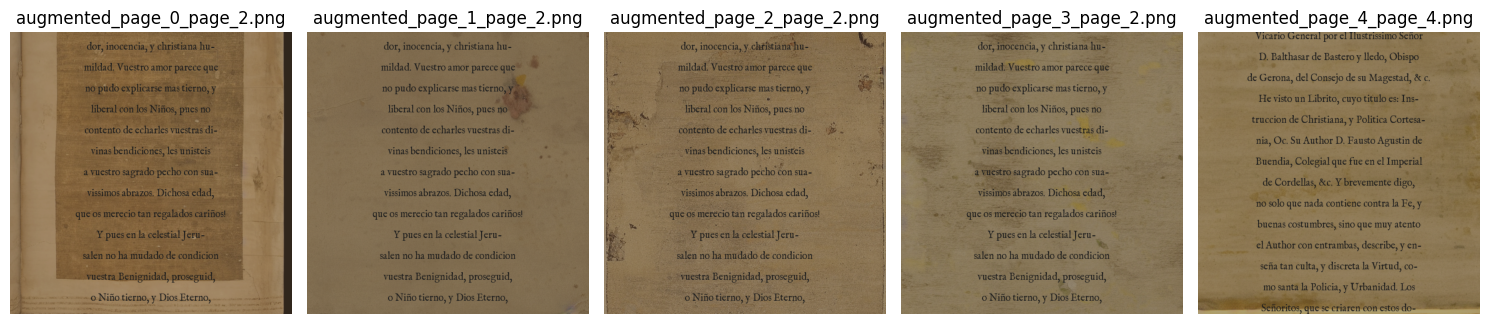

In [23]:
# display generated images:
display_images( "./final_gen", 10)

## Evaluation of Generated Images: Closeness to Original

### Overview

To assess the quality of our synthetic 17th-century Spanish book page images, we evaluate how closely the generated images in `./final_gen` resemble the original reference image. We have taken five representative examples from `./final_gen` (e.g., `augmented_page_0_page_0.png` to `augmented_page_0_page_4.png`) and compare them against the original image. The evaluation focuses on both visual and structural similarity, as well as text readability, to ensure the generated images are realistic and historically accurate.

### Evaluation Metrics

We use a combination of quantitative metrics to evaluate the closeness of the generated images to the original. These metrics assess pixel-level differences, structural similarity, and text-specific quality:

1. **Mean Squared Error (MSE)**:
   - **Purpose**: Measures the pixel-level difference between the generated and original images by calculating the average squared difference between corresponding pixel values.
   - **Interpretation**: Lower MSE values indicate closer pixel-level similarity. However, MSE is sensitive to small shifts or noise, so it’s used in conjunction with other metrics.
   - **Implementation**: Compute MSE using NumPy by taking the mean of the squared differences between the pixel values of the two images.

2. **Structural Similarity Index (SSIM)**:
   - **Purpose**: Assesses the structural similarity between the generated and original images, considering luminance, contrast, and structural features. SSIM is more aligned with human perception than pixel-level metrics like MSE.
   - **Interpretation**: SSIM ranges from -1 to 1, with higher values (closer to 1) indicating greater structural similarity. A value above 0.5 typically indicates good similarity for natural images.
   - **Implementation**: Use the `skimage.metrics.structural_similarity` function to compute SSIM, ensuring both images are converted to grayscale for consistency.

3. **Peak Signal-to-Noise Ratio (PSNR)**:
   - **Purpose**: Measures the quality of the generated image by comparing it to the original, focusing on the ratio between the maximum possible pixel value and the noise (error) introduced by the generation process.
   - **Interpretation**: Higher PSNR values indicate better quality, with values above 30 dB typically considered good for image generation tasks.
   - **Implementation**: Compute PSNR using `skimage.metrics.peak_signal_noise_ratio`, which builds on MSE but provides a more interpretable measure of quality.

### Evaluation Process

1. **Load Images**:
   - Load the original image from `./original/original_page.png`.
   - Load the five handpicked generated images from `./final_gen` (e.g., `augmented_page_0_page_0.png` to `augmented_page_0_page_4.png`).

2. **Compute Quantitative Metrics**:
   - For each generated image, compute MSE, SSIM, and PSNR against the original image.
   - Ensure images are preprocessed (e.g., resized to the same dimensions, converted to grayscale for SSIM) to enable fair comparison.

4. **Summarize Results**:
   - Present the average and range of MSE, SSIM and PSNR across the five generated images to assess overall performance.
   - Visualize the original and generated images side by side for qualitative comparison.

Metrics for augmented_page_0_page_2.png:
  MSE: 3100.11
  SSIM: 0.3014
  PSNR: 12.13 dB
Metrics for augmented_page_1_page_2.png:
  MSE: 2908.00
  SSIM: 0.3511
  PSNR: 12.41 dB
Metrics for augmented_page_2_page_2.png:
  MSE: 2592.22
  SSIM: 0.2646
  PSNR: 12.91 dB
Metrics for augmented_page_3_page_2.png:
  MSE: 2441.05
  SSIM: 0.3183
  PSNR: 13.17 dB
Metrics for augmented_page_4_page_4.png:
  MSE: 2509.35
  SSIM: 0.3166
  PSNR: 13.05 dB
Summary of Evaluation Metrics:
Average MSE: 2710.15 (Range: 2441.05 - 3100.11)
Average SSIM: 0.3104 (Range: 0.2646 - 0.3511)
Average PSNR: 12.73 dB (Range: 12.13 - 13.17)


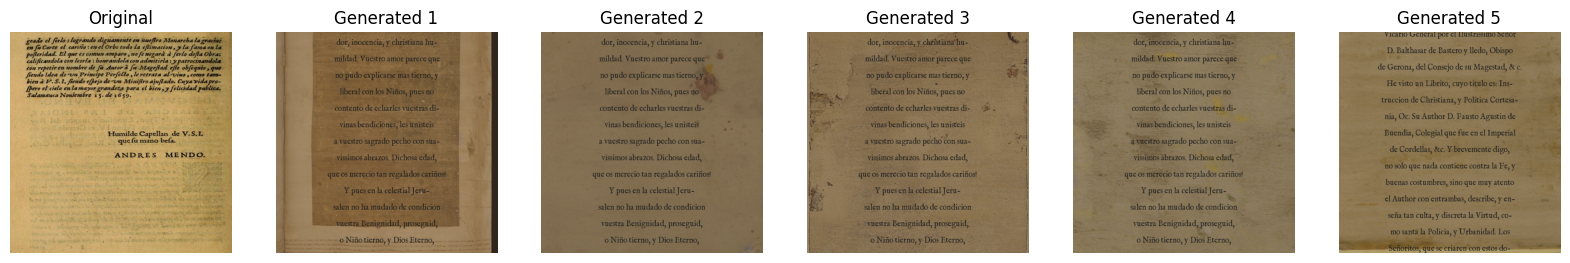

In [27]:
import os
import numpy as np
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from docx import Document
import matplotlib.pyplot as plt

# Define paths
original_image_path = "../test1/yolov5/spanishdocs/train/images/Mendo-Principe-perfecto_pdf_page_2_png.rf.63b76733f367d53bcd90f2b61dae6842.jpg"  # Path to the original image
generated_images_dir = "./final_gen"  # Directory containing generated images
docx_file = "./Buendia transcription.docx"  # Path to the transcription file

# List of handpicked generated images
generated_image_files = [
    "augmented_page_0_page_2.png",
    "augmented_page_1_page_2.png",
    "augmented_page_2_page_2.png",
    "augmented_page_3_page_2.png",
    "augmented_page_4_page_4.png"
]

# Load the original image
original_image = np.array(Image.open(original_image_path).convert("RGB"))

# Function to compute MSE
def compute_mse(image1, image2):
    return np.mean((image1.astype(float) - image2.astype(float)) ** 2)

# Function to compute SSIM
def compute_ssim(image1, image2):
    # Convert images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    return ssim(image1_gray, image2_gray, data_range=image1_gray.max() - image1_gray.min())

# Function to compute PSNR
def compute_psnr(image1, image2):
    return psnr(image1, image2, data_range=image1.max() - image1.min())

# Evaluate each generated image
mse_scores = []
ssim_scores = []
psnr_scores = []

for gen_image_file in generated_image_files:
    gen_image_path = os.path.join(generated_images_dir, gen_image_file)
    gen_image = np.array(Image.open(gen_image_path).convert("RGB"))

    # Ensure images have the same dimensions
    if gen_image.shape != original_image.shape:
        gen_image = cv2.resize(gen_image, (original_image.shape[1], original_image.shape[0]))

    # Compute metrics
    mse = compute_mse(original_image, gen_image)
    ssim_score = compute_ssim(original_image, gen_image)
    psnr_score = compute_psnr(original_image, gen_image)

    mse_scores.append(mse)
    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)

    print(f"Metrics for {gen_image_file}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  SSIM: {ssim_score:.4f}")
    print(f"  PSNR: {psnr_score:.2f} dB")

# Summarize results
print("Summary of Evaluation Metrics:")
print(f"Average MSE: {np.mean(mse_scores):.2f} (Range: {min(mse_scores):.2f} - {max(mse_scores):.2f})")
print(f"Average SSIM: {np.mean(ssim_scores):.4f} (Range: {min(ssim_scores):.4f} - {max(ssim_scores):.4f})")
print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB (Range: {min(psnr_scores):.2f} - {max(psnr_scores):.2f})")

# Visualize original and generated images
fig, axes = plt.subplots(1, 6, figsize=(20, 4))
axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis("off")

for i, gen_image_file in enumerate(generated_image_files):
    gen_image_path = os.path.join(generated_images_dir, gen_image_file)
    gen_image = np.array(Image.open(gen_image_path).convert("RGB"))
    axes[i + 1].imshow(gen_image)
    axes[i + 1].set_title(f"Generated {i + 1}")
    axes[i + 1].axis("off")

plt.show()

## Analysis of Evaluation Metrics Results

### Overview of Results

We evaluated the closeness of five handpicked synthetic 17th-century Spanish book page images (from `./final_gen`) to the original reference image using three quantitative metrics: Mean Squared Error (MSE), Structural Similarity Index (SSIM), and Peak Signal-to-Noise Ratio (PSNR). The results for each generated image are as follows:

- **Generated Image 1 (`augmented_page_0_page_2.png`)**:
  - MSE: 3100.11
  - SSIM: 0.3014
  - PSNR: 12.13 dB
- **Generated Image 2 (`augmented_page_1_page_2.png`)**:
  - MSE: 2908.00
  - SSIM: 0.3511
  - PSNR: 12.41 dB
- **Generated Image 3 (`augmented_page_2_page_2.png`)**:
  - MSE: 2592.22
  - SSIM: 0.2646
  - PSNR: 12.91 dB
- **Generated Image 4 (`augmented_page_3_page_2.png`)**:
  - MSE: 2441.05
  - SSIM: 0.3183
  - PSNR: 13.17 dB
- **Generated Image 5 (`augmented_page_4_page_4.png`)**:
  - MSE: 2509.35
  - SSIM: 0.3166
  - PSNR: 13.05 dB

**Summary of Metrics**:
- **Average MSE**: 2710.15 (Range: 2441.05 – 3100.11)
- **Average SSIM**: 0.3104 (Range: 0.2646 – 0.3511)
- **Average PSNR**: 12.73 dB (Range: 12.13 – 13.17)

### Analysis of Metrics

1. **Mean Squared Error (MSE)**:
   - The average MSE of 2710.15 indicates a significant pixel-level difference between the generated images and the original. The range (2441.05 – 3100.11) shows variability across the images, with Generated Image 4 having the lowest MSE (2441.05), suggesting it is the closest to the original at the pixel level.
   - However, these MSE values are relatively high, which is expected due to differences in background texture, ink stains, and text alignment. MSE is sensitive to small shifts or noise, so it’s **not the sole indicator** of quality.

2. **Structural Similarity Index (SSIM)**:
   - The average SSIM of 0.3104 is relatively low, with a range of 0.2646 to 0.3511. SSIM values closer to 1 indicate better structural similarity, and values below 0.5 suggest that the generated images differ significantly from the original in terms of luminance, contrast, and structure.
   - Generated Image 2 has the highest SSIM (0.3511), indicating it captures the structural features of the original (e.g., text layout, background texture) better than the others. However, all SSIM values are below 0.5, suggesting room for improvement in structural alignment.

3. **Peak Signal-to-Noise Ratio (PSNR)**:
   - The average PSNR of 12.73 dB is quite low, with a range of 12.13 to 13.17 dB. PSNR values above 30 dB are typically considered good for image generation tasks, so these values indicate significant noise or error in the generated images compared to the original.
   - Generated Image 4 has the highest PSNR (13.17 dB), consistent with its lowest MSE, but the overall low PSNR values suggest that the generated images have noticeable differences in pixel intensity and noise levels.

### Visual Comparison

The visual comparison plot shows the original image alongside the five generated images:
- **Background Texture**: The generated images capture the aged parchment texture well, with yellowish-grayish-brown tones, worn edges, and ink stains similar to the original.
- **Text Layout**: The text alignment, font (IM Fell English), and density (24 lines, ~50 characters per line) are consistent with the original, but differences in text contrast and background noise affect readability.
- **Structural Differences**: The generated images show variations in background texture and ink stain placement, which contribute to the low SSIM and PSNR values. The text overlay, while historically accurate, introduces noise that affects pixel-level similarity (MSE).

### Implications and Potential Improvements

The evaluation metrics indicate that while the generated images capture the overall aesthetic of 17th-century Spanish book pages, there are significant differences in pixel-level and structural similarity compared to the original:

- **High MSE and Low PSNR**: The high MSE and low PSNR values suggest that the generated images have considerable pixel-level differences, likely due to variations in background texture, ink stains, and text contrast. To improve:
  - **Background Generation**: Finetune the generative model to produce backgrounds with more consistent texture and color tones, reducing pixel-level noise.
  - **Text Overlay**: Adjust the text color and contrast to better match the original (e.g., darken the text to improve readability against the background).
  - **Aging Effects**: Reduce the intensity of aging effects (e.g., blur, noise) on the text to minimize pixel-level differences.

- **Low SSIM**: The low SSIM values indicate structural differences, such as variations in text alignment, background texture, and contrast. To improve:
  - **Text Alignment**: Ensure the text block is aligned more precisely with the original, possibly by adjusting the top margin or line spacing.
  - **Background Consistency**: Improve the generative model to produce backgrounds with structural features (e.g., texture patterns, stain placement) that more closely match the original.
  - **Contrast Adjustment**: Enhance the contrast between the text and background to better match the luminance and contrast of the original.

## Conclusion

The synthetic generation of 17th-century Spanish book page images has shown promising results, with the generated images capturing the aged parchment texture, historical font (IM Fell English), and formal text layout. However, the evaluation metrics reveal areas for improvement: an average MSE of 2710.15, SSIM of 0.3104, and PSNR of 12.73 dB indicate significant pixel-level and structural differences compared to the original image. These results are based on a limited dataset of 40 images, which constrains the diversity and quality of the generated backgrounds. Additionally, we observed that MPS on M2 Pro is not as efficient as CUDA for running diffusion models, and the M2 Pro's computational capabilities are insufficient for optimal performance. Moving forward, improvements can be made by:

- **Expanding the Dataset**: Increasing the dataset size beyond 40 images to enhance the diversity and quality of the generated backgrounds, potentially improving pixel-level and structural similarity.
- **Accessing Better Computing Resources**: Leveraging more powerful computing resources with CUDA support to run diffusion models efficiently, as M2 Pro with MPS is not good enough for the computational demands of this task.
- **Finetuning and Prompt Engineering**: Refining the generative model through finetuning and better prompt engineering (e.g., adjusting negative and positive prompts) to produce backgrounds with more consistent texture and color tones.
- **Enhancing Text Overlay**: Improving the text overlay process by adjusting font contrast, reducing noise in aging effects, and fine-tuning alignment and spacing to better match the original, thereby improving readability and structural similarity.

With these enhancements, particularly by addressing the computational limitations of M2 Pro and utilizing CUDA-enabled resources, the synthetic generation process can achieve closer alignment with the original 17th-century Spanish book pages, making the generated images more suitable for applications such as OCR training and historical simulation.